# YellowHat-Bot

---



## Cell 1 — Install dependencies (run once)

In [ ]:
!python3 -m pip install --upgrade pip
!python3 -m pip install numpy matplotlib pandas

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x750c07b0>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/pip/
Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x750c0390>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/pip/
Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x750c04d0>: Failed to establish a new connection: [Errno 111] Connection refused',)': /simple/pip/
Retrying (Retry(total=1, connect=None, read=

## Cell 2 — Imports and constants

In [ ]:
import os
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET


CM_PER_SVG_UNIT = 0.254

USE_WIDGET_UPLOAD = False


## Cell 3 — Load SVG (recommended: filename-based upload)
1) Upload/copy your `.svg` into the same folder as this notebook (Jupyter file browser Upload button, or scp).
2) Run this cell and type the filename.

If you want to try widget upload, set `USE_WIDGET_UPLOAD=True` in Cell 2.

In [ ]:
svg_bytes = None
svg_name = None

if USE_WIDGET_UPLOAD:
    try:
        from ipywidgets import FileUpload
        from IPython.display import display

        uploader = FileUpload(accept=".svg", multiple=False)
        display(uploader)
        print("Upload your SVG above, then run Cell 4.")
    except Exception as e:
        print("Widget upload unavailable; falling back to filename mode.")
        USE_WIDGET_UPLOAD = False

if not USE_WIDGET_UPLOAD:
    svgs = sorted([f for f in os.listdir('.') if f.lower().endswith('.svg')])
    print("SVG files in this folder:")
    for f in svgs:
        print(" -", f)

    if not svgs:
        print("\nNo SVG files found. Upload one via Jupyter file browser, then re-run this cell.")
    else:
        svg_name = input("\nType the SVG filename exactly: ").strip()
        with open(svg_name, "rb") as f:
            svg_bytes = f.read()
        print("Loaded:", svg_name, "| bytes:", len(svg_bytes))


SVG files in this folder:
 - parking-diagram.svg
Loaded: parking-diagram.svg | bytes: 2363


## Cell 4 — If using widget upload, capture bytes

In [ ]:
if USE_WIDGET_UPLOAD:
    if not uploader.value:
        raise RuntimeError("No file uploaded yet. Upload the SVG, then re-run this cell.")
    svg_name = list(uploader.value.keys())[0]
    svg_bytes = bytes(uploader.value[svg_name]['content'])
    print("Loaded:", svg_name, "| bytes:", len(svg_bytes))
else:
    if svg_bytes is None:
        raise RuntimeError("SVG bytes not loaded. Use filename mode in Cell 3.")


## Cell 5 — Parse SVG geometry (lines + rects only)


In [ ]:
def _strip_ns(tag: str) -> str:
    return tag.split('}', 1)[-1] if '}' in tag else tag

def parse_svg_lines_and_rects(svg_bytes: bytes):
    root = ET.fromstring(svg_bytes)
    segments = []

    for el in root.iter():
        tag = _strip_ns(el.tag)

        if tag == "line":
            x1 = float(el.attrib.get("x1", "0"))
            y1 = float(el.attrib.get("y1", "0"))
            x2 = float(el.attrib.get("x2", "0"))
            y2 = float(el.attrib.get("y2", "0"))
            segments.append(((x1, y1), (x2, y2)))

        elif tag == "rect":
            x = float(el.attrib.get("x", "0"))
            y = float(el.attrib.get("y", "0"))
            w = float(el.attrib.get("width", "0"))
            h = float(el.attrib.get("height", "0"))
            segments.extend([
                ((x, y), (x + w, y)),
                ((x + w, y), (x + w, y + h)),
                ((x + w, y + h), (x, y + h)),
                ((x, y + h), (x, y)),
            ])

    if not segments:
        raise ValueError("No <line> or <rect> geometry found in the SVG.")

    return segments

raw_segments = parse_svg_lines_and_rects(svg_bytes)
print("Parsed segments:", len(raw_segments))


Parsed segments: 8


## Cell 6 — Normalize to SW origin and convert to centimeters


In [ ]:
def normalize_to_sw_cm(segments, cm_per_svg_unit=0.254):
    pts = np.array([p for seg in segments for p in seg], dtype=float)
    max_y = float(pts[:, 1].max())
    min_x = float(pts[:, 0].min())

    out = []
    for (x1, y1), (x2, y2) in segments:

        x1s = (x1 - min_x)
        x2s = (x2 - min_x)

        y1s = (max_y - y1)
        y2s = (max_y - y2)

        out.append(((x1s * cm_per_svg_unit, y1s * cm_per_svg_unit),
                    (x2s * cm_per_svg_unit, y2s * cm_per_svg_unit)))
    return out

segments_cm = normalize_to_sw_cm(raw_segments, CM_PER_SVG_UNIT)


## Cell 7 — Build an instruction table (coordinates + PEN state)
- PEN is **DOWN** on drawable segments
- PEN is **UP** while traveling to the next segment start
By default, travel moves are straight-line (may be diagonal).

In [ ]:
def heading_deg_xy(x0, y0, x1, y1):
    dx = float(x1 - x0)
    dy = float(y1 - y0)
    return math.degrees(math.atan2(dy, dx))

def dist_cm_xy(x0, y0, x1, y1):
    return float(np.linalg.norm(np.array([x1 - x0, y1 - y0])))

def build_instructions_xy(segments_cm, start_xy=(0.0, 0.0)):
    rows = []
    cx, cy = float(start_xy[0]), float(start_xy[1])
    step = 1

    for (p0, p1) in segments_cm:
        x0, y0 = float(p0[0]), float(p0[1])
        x1, y1 = float(p1[0]), float(p1[1])

        if dist_cm_xy(cx, cy, x0, y0) > 1e-6:
            rows.append(dict(
                step=step, pen="UP",
                from_x=cx, from_y=cy,
                to_x=x0,  to_y=y0,
                distance_cm=dist_cm_xy(cx, cy, x0, y0),
                heading_deg=heading_deg_xy(cx, cy, x0, y0),
            ))
            step += 1
            cx, cy = x0, y0

        rows.append(dict(
            step=step, pen="DOWN",
            from_x=x0, from_y=y0,
            to_x=x1,  to_y=y1,
            distance_cm=dist_cm_xy(x0, y0, x1, y1),
            heading_deg=heading_deg_xy(x0, y0, x1, y1),
        ))
        step += 1
        cx, cy = x1, y1

    return pd.DataFrame(rows)

df = build_instructions_xy(segments_cm, start_xy=(0.0, 0.0))
df.head(20)

,distance_cm,from_x,from_y,heading_deg,pen,step,to_x,to_y
0,179.832000,0.00,0.000000,90.0,UP,1,0.00,179.832000
1,274.320000,0.00,179.832000,0.0,DOWN,2,274.32,179.832000
2,179.832000,274.32,179.832000,-90.0,DOWN,3,274.32,0.000000
3,274.320000,274.32,0.000000,180.0,DOWN,4,0.00,0.000000
4,179.832000,0.00,0.000000,90.0,DOWN,5,0.00,179.832000
5,274.320000,0.00,179.832000,0.0,DOWN,6,274.32,179.832000
6,179.826666,274.32,179.832000,-90.0,DOWN,7,274.32,0.005334
7,274.320000,274.32,0.005334,180.0,DOWN,8,0.00,0.005334
8,179.826666,0.00,0.005334,90.0,DOWN,9,0.00,179.832000


## Cell 8 — Optional: Force 90° travel for PEN_UP moves (Manhattan travel)
If you want *no diagonal travel* between segments, enable this.

In [ ]:
USE_MANHATTAN_UP_MOVES = True

def manhattanize_up_moves_xy(df_in, x_first=True):
    out = []

    for row in df_in.itertuples(index=False):
        d = row._asdict()

        if d["pen"] != "UP":
            out.append(d)
            continue

        x0, y0 = d["from_x"], d["from_y"]
        x1, y1 = d["to_x"], d["to_y"]

        if abs(x1 - x0) < 1e-6 or abs(y1 - y0) < 1e-6:
            out.append(d)
            continue

        if x_first:
            mx, my = x1, y0
        else:
            mx, my = x0, y1

        d1 = dict(d)
        d1["to_x"], d1["to_y"] = mx, my
        d1["distance_cm"] = dist_cm_xy(x0, y0, mx, my)
        d1["heading_deg"]  = heading_deg_xy(x0, y0, mx, my)

        d2 = dict(d)
        d2["from_x"], d2["from_y"] = mx, my
        d2["to_x"], d2["to_y"] = x1, y1
        d2["distance_cm"] = dist_cm_xy(mx, my, x1, y1)
        d2["heading_deg"]  = heading_deg_xy(mx, my, x1, y1)

        out.append(d1)
        out.append(d2)

    for i, r in enumerate(out, start=1):
        r["step"] = i

    return pd.DataFrame(out)

df_exec = manhattanize_up_moves_xy(df) if USE_MANHATTAN_UP_MOVES else df.copy()
df_exec.head(20)


,distance_cm,from_x,from_y,heading_deg,pen,step,to_x,to_y
0,179.832000,0.00,0.000000,90.0,UP,1,0.00,179.832000
1,274.320000,0.00,179.832000,0.0,DOWN,2,274.32,179.832000
2,179.832000,274.32,179.832000,-90.0,DOWN,3,274.32,0.000000
3,274.320000,274.32,0.000000,180.0,DOWN,4,0.00,0.000000
4,179.832000,0.00,0.000000,90.0,DOWN,5,0.00,179.832000
5,274.320000,0.00,179.832000,0.0,DOWN,6,274.32,179.832000
6,179.826666,274.32,179.832000,-90.0,DOWN,7,274.32,0.005334
7,274.320000,274.32,0.005334,180.0,DOWN,8,0.00,0.005334
8,179.826666,0.00,0.005334,90.0,DOWN,9,0.00,179.832000


## Cell 9 — Preview plot (DOWN=black, UP=red dashed)

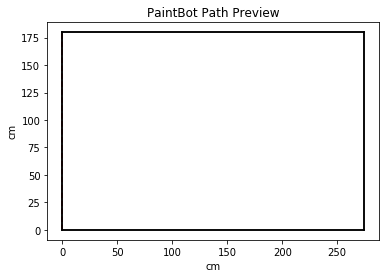

In [ ]:
plt.figure()
for row in df_exec.itertuples(index=False):
    x0, y0 = row.from_x, row.from_y
    x1, y1 = row.to_x, row.to_y
    if row.pen == "DOWN":
        plt.plot([x0, x1], [y0, y1], "k-")
    else:
        plt.plot([x0, x1], [y0, y1], "r--")

plt.gca().set_aspect("equal")
plt.xlabel("cm")
plt.ylabel("cm")
plt.title("PaintBot Path Preview")
plt.show()

## Cell 10 — Connect GoPiGo3 + SERVO2 (pencil)

In [ ]:
try:
    import easygopigo3 as easy
    gpg = easy.EasyGoPiGo3()
    servo2 = gpg.init_servo("SERVO2")
    print("GoPiGo connected. SERVO2 initialized.")
except Exception as e:
    print("GoPiGo not connected. SIMULATION mode.")
    print("Reason:", e)
    gpg = None
    servo2 = None


GoPiGo connected. SERVO2 initialized.


## Cell 11 — Speed + pen calibration


In [ ]:
DRIVE_SPEED = 250
TURN_SPEED = 150

PEN_UP_ANGLE = 0
PEN_DOWN_ANGLE = 90

if gpg is not None:
    gpg.set_speed(DRIVE_SPEED)
    try:
        gpg.set_turn_speed(TURN_SPEED)
    except Exception:
        pass

def pen_up():
    if servo2 is None:
        print("[SIM] PEN UP")
        return
    servo2.rotate_servo(PEN_UP_ANGLE)
    time.sleep(0.2)

def pen_down():
    if servo2 is None:
        print("[SIM] PEN DOWN")
        return
    servo2.rotate_servo(PEN_DOWN_ANGLE)
    time.sleep(0.2)

pen_up(); time.sleep(0.4); pen_down(); time.sleep(0.4); pen_up()


## Cell 12 — Turn/drive helpers

In [ ]:
def wrap_angle_deg(a):
    return (a + 180) % 360 - 180

def turn_relative(deg):
    if gpg is None:
        print(f"[SIM] turn {deg:.2f}°")
        return
    if abs(deg) > 0.5:
        gpg.turn_degrees(deg)

def drive_forward_cm(cm):
    if gpg is None:
        print(f"[SIM] drive {cm:.2f} cm")
        return
    if cm > 0.1:
        gpg.drive_cm(cm)


## Cell 13 — Execute the demo


In [ ]:
START_HEADING_DEG = 0.0  # 0=east/+X, 90=north/+Y

def run_demo(df_steps, start_heading_deg=0.0, settle_s=0.05):
    """
    Executes df_steps which must contain:
    pen, from_x, from_y, to_x, to_y
    Assumes the robot is placed at the SW corner of the layout and starts facing +X.
    """
    current_heading = float(start_heading_deg)

    pen_up()

    for row in df_steps.itertuples(index=False):
        pen = row.pen

        x0, y0 = float(row.from_x), float(row.from_y)
        x1, y1 = float(row.to_x), float(row.to_y)

        tgt_heading = heading_deg_xy(x0, y0, x1, y1)
        turn = wrap_angle_deg(tgt_heading - current_heading)
        d = dist_cm_xy(x0, y0, x1, y1)

        if pen == "DOWN":
            pen_down()
        else:
            pen_up()

        turn_relative(turn)
        drive_forward_cm(d)

        current_heading = tgt_heading
        time.sleep(settle_s)

    pen_up()
    print("Demo complete.")

run_demo(df_exec, start_heading_deg=START_HEADING_DEG, settle_s=0.05)

Demo complete.


## Cell 14 — Export instructions (optional)

In [ ]:
df_exec.to_csv("paintbot_instructions.csv", index=False)
print("Saved: paintbot_instructions.csv")
